# Metacells for gut tube RNA seq data
Use diffusion map to iteratively reassign cluster centers via k-medoids

In [1]:
from importlib import reload
import numpy as np
import os
import scanpy as sc

## Load data

In [2]:
data_fname = os.path.join("..", "ot", "data", "pbmc", "rna_10k.h5ad")
ad = sc.read(data_fname)

print(ad)

AnnData object with n_obs × n_vars = 7630 × 15365 
    obs: 'n_genes', 'percent_mito', 'cluster', 'celltype'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'ADT-cols'
    obsm: 'ADT', 'UMAP'


## Cleaning

In [3]:
sc.pp.filter_cells(ad, min_counts=10, inplace=True)
sc.pp.filter_genes(ad, min_counts=10, inplace=True)

print(ad)

AnnData object with n_obs × n_vars = 7630 × 15343 
    obs: 'n_genes', 'percent_mito', 'cluster', 'celltype', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'n_counts'
    uns: 'ADT-cols'
    obsm: 'ADT', 'UMAP'


In [4]:
# store raw data
ad.raw = ad

## Library size normalization and log transform

In [5]:
from scipy.sparse import csr_matrix

# pseudocount for log transformation
ps = 0.1

# library size normalization
sc.pp.normalize_total(ad)

# reset data
new_data = np.log(ad.X.data + ps) - np.log(ps)
ad.X = csr_matrix((new_data, ad.X.indices, ad.X.indptr), shape=ad.X.shape)

## Highly variable genes

In [6]:
sc.pp.highly_variable_genes(ad, flavor="cell_ranger", n_top_genes=3000)
print(ad)

AnnData object with n_obs × n_vars = 7630 × 15343 
    obs: 'n_genes', 'percent_mito', 'cluster', 'celltype', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'ADT-cols'
    obsm: 'ADT', 'UMAP'


In [7]:
# basic visualization
sc.tl.pca(ad, use_highly_variable=True)
sc.pp.neighbors(ad)
sc.tl.diffmap(ad)

In [9]:
sc.tl.draw_graph(ad)

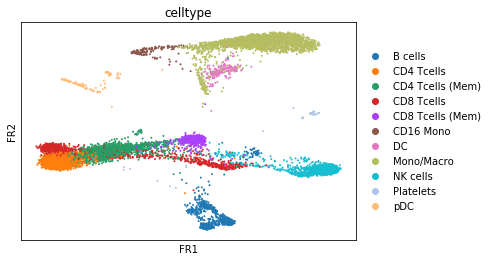

In [10]:
sc.pl.draw_graph(ad, color=["celltype"])

# Metacells

In [11]:
import diffkm

In [15]:
reload(diffkm)

model = diffkm.diffkm(ad.obsm["X_pca"], verbose=False)
model.initialize_kernel_rbf_parallel(15)

In [16]:
model.compute_transition_probabilities()
model.compute_diffusion_map(15, 5)

In [17]:
model.cluster(200)

Initializing residual matrix...



Converged after 2 iterations!
Assigning clusters...


# Visualization

In [18]:
print(model.compute_modularity())

0.29788197782548814


Minimum metacell size: 18


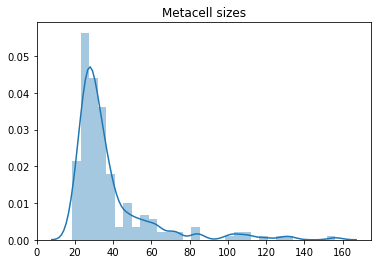

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.distplot(model.get_soft_metacell_sizes())
plt.title("Metacell sizes")

print("Minimum metacell size: %d" % min(model.get_soft_metacell_sizes()))

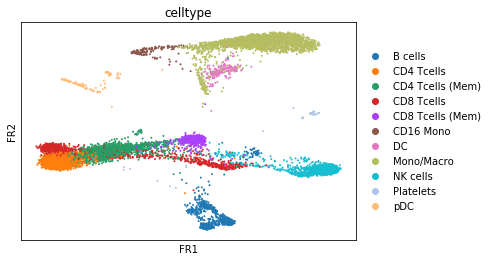

In [21]:
sc.pl.draw_graph(ad, color=["celltype"])

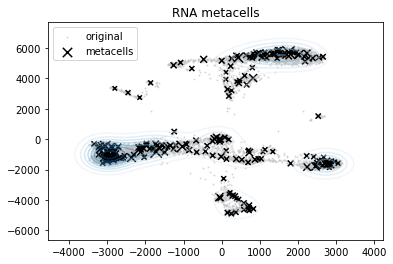

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

sizes = model.get_soft_metacell_sizes()

key = "X_draw_graph_fr"
ix1 = 0
ix2 = 1

sns.kdeplot(ad.obsm[key][:,ix1], ad.obsm[key][:,ix2], cmap="Blues", alpha=0.5)
plt.scatter(ad.obsm[key][:,ix1], ad.obsm[key][:,ix2],
            c="silver",
            s=1., label="original", alpha=0.5)

#coords = model.get_metacell_coordinates(hv_ad.obsm[key], exponent=1)
coords = ad.obsm[key][model.centers,:]
plt.scatter(coords[:,ix1], coords[:,ix2],
           c="k", marker="x", s=sizes, label="metacells")

plt.title("RNA metacells")
plt.legend()

# Save AnnData with metacell sizes

In [24]:
metacell_coords = model.get_metacell_coordinates(ad.raw.X)

print(metacell_coords.shape)

(200, 15343)


In [29]:
# create new AnnData
metacell_ad = sc.AnnData(metacell_coords)
metacell_ad.obs = ad[model.centers].obs.copy()
metacell_ad.var = ad.var

# add sizes
metacell_ad.obs["size"] = model.get_soft_metacell_sizes()

In [30]:
metacell_ad.obs

,n_genes,percent_mito,cluster,celltype,n_counts,size
TTGGATGAGATCCAAA-1,1440,0.065520,5,CD8 Tcells,4533.0,110.068436
TGCAGTAGTACAGTCT-1,1232,0.053856,3,NK cells,2451.0,18.748057
TCAGGTAAGCAATAGT-1,1054,0.036697,6,CD8 Tcells,2289.0,27.618222
ATTTACCCAGCGGTCT-1,1187,0.039271,1,CD4 Tcells,3514.0,39.017220
ACCATTTCATGCCGAC-1,1310,0.042480,3,NK cells,2613.0,118.891449
...,...,...,...,...,...,...
ACAGGGATCCGCACTT-1,1520,0.035865,1,CD4 Tcells,4489.0,32.388578
TTAGTCTCAAGAGAGA-1,1247,0.054424,1,CD4 Tcells,3436.0,110.280230
GTCTAGACACATCATG-1,1555,0.060221,9,B cells,5430.0,64.401755
AAGATAGAGCGAACTG-1,2765,0.049553,11,CD16 Mono,10292.0,36.300311


In [31]:
metacell_ad.var

,gene_ids,feature_types,genome,n_cells,n_counts,highly_variable,means,dispersions,dispersions_norm
AL627309.1,ENSG00000238009,Gene Expression,GRCh38,12,12.0,False,0.003495,2.285420,0.323013
AL669831.5,ENSG00000237491,Gene Expression,GRCh38,446,459.0,False,0.120244,2.092940,-0.712233
LINC00115,ENSG00000225880,Gene Expression,GRCh38,180,182.0,False,0.049910,2.198724,0.041486
FAM41C,ENSG00000230368,Gene Expression,GRCh38,298,308.0,False,0.080428,2.120842,-0.544631
NOC2L,ENSG00000188976,Gene Expression,GRCh38,1547,1850.0,False,0.452796,1.917543,-0.215624
...,...,...,...,...,...,...,...,...,...
AL592183.1,ENSG00000273748,Gene Expression,GRCh38,737,784.0,False,0.211408,2.106318,0.724124
AC007325.4,ENSG00000278817,Gene Expression,GRCh38,59,59.0,False,0.016422,2.201855,-0.293665
AL354822.1,ENSG00000278384,Gene Expression,GRCh38,30,30.0,False,0.007960,2.223497,-0.130803
AC004556.1,ENSG00000276345,Gene Expression,GRCh38,1245,1519.0,False,0.341308,1.864737,-2.434304


# Downstream analysis to make sure things look ok

In [32]:
metacell_ad_2 = metacell_ad.copy()

# normalization
sc.pp.normalize_total(metacell_ad_2)
sc.pp.log1p(metacell_ad_2)

# dim reduction
sc.tl.pca(metacell_ad_2, use_highly_variable=True)
sc.pp.neighbors(metacell_ad_2)
sc.tl.diffmap(metacell_ad_2)

# visualization
sc.tl.draw_graph(metacell_ad_2)

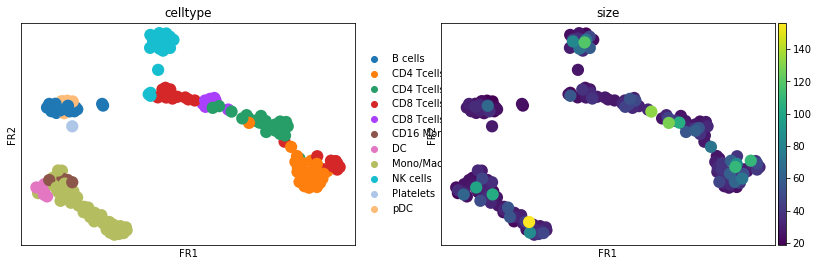

In [35]:
sc.pl.draw_graph(metacell_ad_2, color=["celltype", "size"])

In [36]:
print(metacell_ad)

AnnData object with n_obs × n_vars = 200 × 15343 
    obs: 'n_genes', 'percent_mito', 'cluster', 'celltype', 'n_counts', 'size'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'


In [37]:
save_fname = os.path.join("..", "ot", "data", "pbmc", "rna_10k_metacells.h5ad")
metacell_ad.write_h5ad(save_fname)